# Group Exercise #2

In this graded group exercise, you will use the **GEE Python API** and the **geemap Python package** to:

- Retrieve a collection of satellite images over a study area
- Create a composite image and visualize it
- Apply a simple unsupervised machine learning algorithm (e.g., k-means) for clustering the study area
- Analyze the clustering results given a set of reference points

### Points of Discussions

- Why do we need to train an unsupervised classifier in GEE?
- Impact of the number clusters on the results
- Impact of performing the clustering in region X and applying it on region Y
  - Region Y has the same land cover classes present in Region X
  - Region Y has more land cover classes/types.
- What can you say about the computational time?

## 1 Task Implementation (for Turkey)

### 1.1 Define a case study area 
*The size of bounding box covering the study area should be large enough (e.g., few hundred kilometers).* 

Before we start the process, the initialization of the API needs to be done.
- Two packages are needed: `ee` and `geemap`
- The authentication line is necessary to access the resources in Google Earth Engine. And it should be run at first and follow the instructions. Then the Python environment knows the authentication and it needn't be executed anymore.

In [34]:
import ee
import geemap
import sys

#   Please run this just once to get access to the resources in GEE
#ee.Authenticate()

try:
    # Initialize the library
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


We select Turkey as the area of interest and create its bounding box.

In [35]:
# Bounding box of Turkey (Define the region of interest as a polygon)
left = 28.0391 #25.663
right = 32.1919#44.822
up= 37.5306 #42.366
down = 39.4904 #35.817 
roi = ee.Geometry.Polygon(
        [[[left, down],
          [right, down],
          [right, up],
          [left, up],]], None, False)

bbox = roi.bounds().getInfo()['coordinates'][0]
print(bbox)

[[28.0391, 37.5306], [32.1919, 37.5306], [32.1919, 39.4904], [28.0391, 39.4904], [28.0391, 37.5306]]


Then we center Turkey at the center of the map and add the bounding box as a layer.

In [36]:
# Create a map centered on Turkey
map = geemap.Map(center=[(up+down)/2, (left+right)/2], zoom=6)

# Add the bounding box to the map
bbox_layer = geemap.geojson_to_ee({
    'type': 'Feature',
    'geometry': {
        'type': 'Polygon',
        'coordinates': [bbox]
    },
    'properties': {
        'name': 'Bounding box'
    }
})
map.addLayer(bbox_layer, {'color': 'grey'}, 'Bounding box')

# Display the map
map

Map(center=[38.5105, 30.115499999999997], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

### 1.2 Add the reference points
*Filter the reference points to the selected region of interest*

- The reference points are stored in the multiple .csv file under /Reference_Point
- We read them as DataFrame first and then convert it to ee FeatureCollection.

NB! Task was solved with three solutions (A, B, C), each of which runs parallelly with the others. So you just need to run one of them for the whole assignment. For this document, we ran Solution C.

#### 1.2.1 Solution A
- As Google Earth API cannot handle external data larger than 10Mb, so we need to avoid making a big complete ee FeatureColleciton of all points and handle it by ee package. Instead, we need to decrease the size of the ee FeatureCollection.
- Therefore, here we read all the points into dataframe first and finishe the filtering when it was still a dataframe.
- Then, we convert this smaller dataframe into ee FeatureCollection.
- This method took 9.1 seconds to finish on my laptop locally. (We need Internet connection after the conversion from dataframe, like half the process)

In [37]:
# import dask.dataframe as dd
# import pandas as pd

# # Use DASK to read all csv together
# da = dd.read_csv('Reference_Point/SamplesSet*.csv')
# ref_point = da.compute()

# # Get rid of the rows with no landcover
# ref_point = ref_point.dropna(subset=['landcover'])

# # Filter the data withi the area of interest
# ref_point_sub = ref_point[(ref_point['lon'] >= left) & (ref_point['lon'] <= right) & (ref_point['lat'] >= down) & (ref_point['lat'] <= up)]

# print(ref_point_sub)

# # Convert the data to a ee feature
# def row_to_feature(row):
#     point = ee.Geometry.Point(row['lon'], row['lat'])
#     feature = ee.Feature(point, {'landcover': row['landcover']})
#     return feature

# # Make feature collection
# feature_list = ref_point_sub.apply(row_to_feature,axis=1).tolist()
# feature_collection = ee.FeatureCollection(feature_list)
# ref_point_ee = feature_collection.filter(ee.Filter.geometry(roi))
# print(ref_point_ee.size().getInfo())


#### 1.2.2 Solution B
NB. the solution also exceeds the 10Mb limit, so it is not the best solution.

- Same reason for Solution A, Google Earth API cannot handle external data larger than 10Mb. Solution B tries to avoid online calculation with big dataset by making loops to handle the process separately. 
- Here the way could be loop around each csv file, convert it into ee FeatureCollection, filter it and then merge the selected point with the result of last loop.
- This solution keeps calling Google Earth, therefore robust net connection for the whole process is necessary.

In [38]:
# import dask.dataframe as dd
# import pandas as pd

# # Convert the data to a ee feature
# def row_to_feature(row):
#     point = ee.Geometry.Point(row['lon'], row['lat'])
#     feature = ee.Feature(point, {'landcover': row['landcover']})
#     return feature

# ref_point= pd.DataFrame({})
# ref_point_ee= ee.FeatureCollection([])
# # loop each csv and run the process separately
# for i in range(1,11):
#     path= 'Reference_Point/SamplesSet'+ str(i) +'.csv'
#     ref_point_sub = pd.read_csv(path)
#     ref_point_sub = ref_point_sub.dropna(subset=['landcover'])
#     # merge the dataframe
#     ref_point = pd.concat([ref_point,ref_point_sub])
#     # convert the dataframe to ee feature
#     feature_list = ref_point_sub.apply(row_to_feature,axis=1).tolist()
#     feature_collection = ee.FeatureCollection(feature_list)
#     filtered_collection = feature_collection.filter(ee.Filter.geometry(roi))
#     # merge the feature collection
#     ref_point_ee = ref_point_ee.merge(filtered_collection)
#     # print(ref_point_ee.size().getInfo())


#### 1.2.3 Solution C
- Solution C avoids online calculating with big dataset by using geopandas to handle geo objects.
- We could add the points as geodataframe and filter it with the area of interest locally with geopandas
- And then we transfer the geodataframe into ee. objest. So the input for the geemap occupies a much smaller storage.
- This solution takes 6.9 seconds. It just needs Internet for the last step.

In [39]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd

# use DASK to read all csv together
da = dd.read_csv('ref_pts/ref_pts/SamplesSet*.csv')
ref_point = da.compute()

# Get rid of the rows with no landcover
ref_point = ref_point.dropna(subset=['landcover'])

# Convert the dataframe to geodataframe
geometry = [Point(xy) for xy in zip(ref_point['lon'], ref_point['lat'])]
gdf = gpd.GeoDataFrame(ref_point, geometry=geometry, crs='EPSG:4326')
gdf = gdf.drop(['lon', 'lat'], axis=1)

# Filter the points in the area of interest
area_of_interest = Polygon([(left, down), (right, down), (right, up), (left, up)])
gdf_ref_point_sub = gdf.cx[left:right, down:up]

# Convert the geodataframe to ee
ref_point_ee = geemap.geopandas_to_ee(gdf_ref_point_sub)

### 1.3 & 1.4. Generate image collection & Calculate the median image
Generate Sentinel 2 images for this region of interest covering the summer of 2023
Reduce this image collection by calculating the median of all values

In [40]:
# To mask clouds in Sentinel-2 image using QA band
def mask_s2_clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )
  # Return the image after the mask is applied and divide it by 10000 to scale the values around 0-1 
  return image.updateMask(mask).divide(10000)

# Get the Sentinel-2 image collection for the region of interest
image = (
     ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
    .filterBounds(roi) 
    # Summer 2023
    .filterDate('2023-06-01', '2023-08-31') 
    # Pre-filter to get less cloudy granules.
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10) 
    .map(mask_s2_clouds)
    # Get the median of the image collection
    .median()
)

# Set visualization parameters for visulization
vis_params = {
    'min': 0,'max': 0.4,
    'bands': ["B4", "B3", "B2"]
}

### 1.5. Visualize the reference points and image
*Make the image and visualisation together on one map*

In [41]:
# Find the 'Bounding box' layer and hide it
bbox_layer = map.find_layer('Bounding box')
bbox_layer.visible = False

# Set visualization parameters for visulization of image
vis_params = {
    'min': 0,'max': 0.4,
    'bands': ["B4", "B3", "B2"]
}
# Add the image to the map
map.addLayer(image, vis_params, 'S2-2023-Median')

# Add the reference points to the map
map.addLayer(ref_point_ee, {}, 'Area_of_Interest')
map


Map(center=[38.5105, 30.115499999999997], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

### 1.6. Make cluster
- *Cluster the selected image into a predefined number of clusters*
- *You can use the reference points labels to get a first estimation of number of clusters and k-mean as the clustering algorithm*

In [42]:
# Select the sample points to train the K-means model
training = image.sample(**{
    'scale': 30,
    # 8000 points in total
    'numPixels': 8000,
    'seed': 0,
    'geometries': True, 
    'region': roi,
    # set the tilescan to reduce the occupancy of the storage
    'tileScale': 4
})

In [43]:
# Set the cluster number as 5 (the reference points have 5 types of landcover)
cluster_number = 5
clusterer = ee.Clusterer.wekaKMeans(cluster_number).train(training)

# Cluster the input using the trained clusterer.
image_clustered = image.cluster(clusterer)

# Display the clusters with random colors.
map.addLayer(image_clustered.randomVisualizer(), {}, 'clusters')
map

Map(center=[38.5105, 30.115499999999997], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

### 1.7. Analyze the clustering results. 
For example, you can use histogram of the land cover classes per cluster id generated by the k-means algorithm.

- First, we join the cluster id into the refernce points based on the geometries and then do visualization for clustering results
- Per Cluster ID, we visualised the distribution of different land cover groups (x-axis is different cluster, y-axis is number of reference points of this land cover on the cluster)
- We also calculted the V-measure index (a comprehensive index evaluating the homogeneity in one cluster and the completeness from different clusters) to quantify the quality of the clustering

In [44]:
# Join the value of clustered image (cluster_id) into reference point
joined_ref_point_ee = image_clustered.reduceRegions(
    collection=ref_point_ee,
    reducer=ee.Reducer.mean(),
    crs='EPSG:4326',
    scale = 30,
    tileScale = 4
)

Join the cluster id into the refernce points based on the geometries and then do visualization for clustering results

In [45]:
# Convert the reference point with joined cluster_id into geodataframe for visualisation
joined_ref_point_geop = geemap.ee_to_geopandas(joined_ref_point_ee)
joined_ref_point_geop = joined_ref_point_geop.rename(columns={"mean": "cluster_id"})
joined_ref_point_geop.head()

,geometry,landcover,cluster_id
0,POINT (30.20294 37.97201),ForestNaturalAreas,4
1,POINT (30.89801 38.54468),AgriculturalArea,0
2,POINT (30.46509 37.97582),AgriculturalArea,3
3,POINT (30.48277 37.60441),AgriculturalArea,3
4,POINT (28.11941 38.56748),Water,4


Text(0.5, 1.0, 'Assigned Cluster of Refernence Points with 5 Clusters')

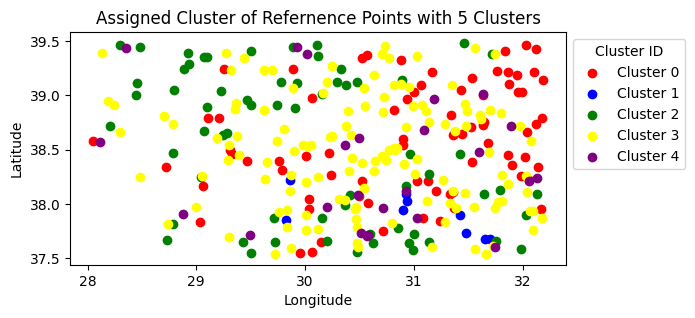

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
# Define a color map for each cluster_id
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'purple'
}
# Split and plot data for each cluster_id
for cluster, color in color_map.items():
    subset = joined_ref_point_geop[joined_ref_point_geop['cluster_id'] == cluster]
    subset.plot(ax=ax, color=color, label=f"Cluster {cluster}")
# Add legend
ax.legend(title="Cluster ID", loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(label="Assigned Cluster of Refernence Points with 5 Clusters", fontsize=12, color="Black")

Text(0.5, 1.0, 'Assigned Cluster of Refernence Points with 5 Clusters')

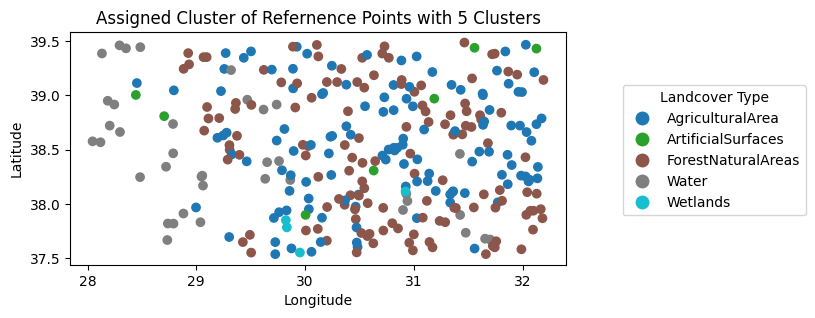

In [47]:
fig, ax = plt.subplots(1,1)
joined_ref_point_geop.plot(ax = ax, column= 'landcover', legend = True,  legend_kwds={'title': 'Landcover Type' ,'bbox_to_anchor':(1.1, 0.8),} )
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(label="Assigned Cluster of Refernence Points with 5 Clusters", fontsize=12, color="Black")

In [48]:
# Convert the reference point with joined cluster_id into dataframe
joined_ref_point= joined_ref_point_geop.drop(['geometry'], axis=1)
joined_ref_point.head()

,landcover,cluster_id
0,ForestNaturalAreas,4
1,AgriculturalArea,0
2,AgriculturalArea,3
3,AgriculturalArea,3
4,Water,4


Visualise and evaluate the clustering result:

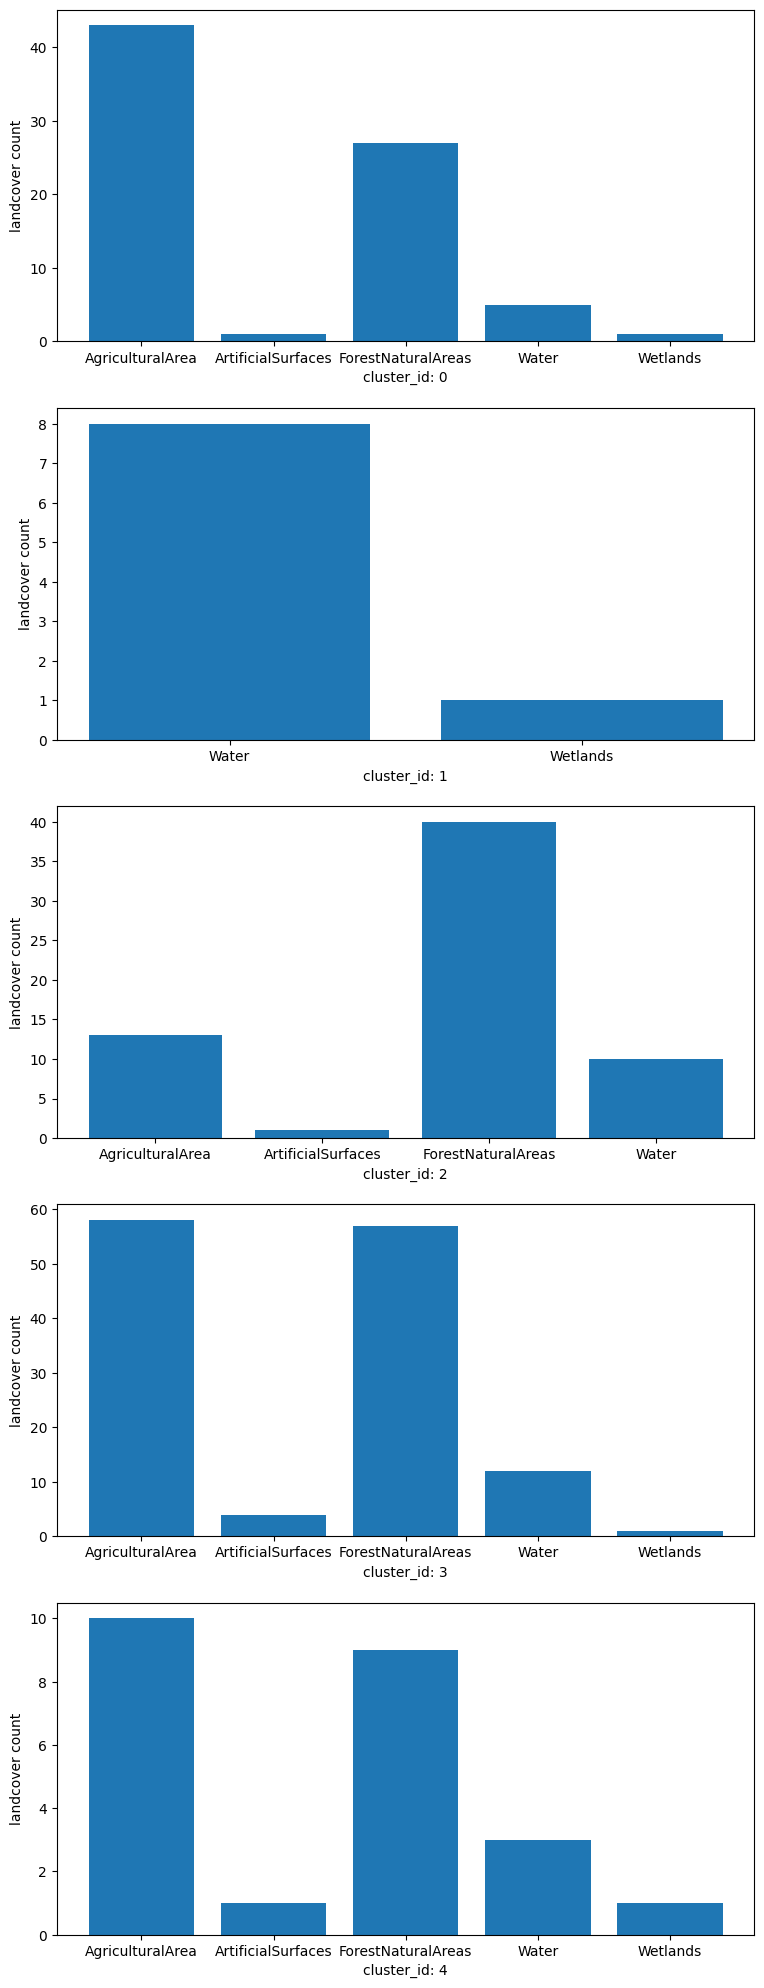

In [49]:

import matplotlib.pyplot as plt
# reshape the dataframe to pivot-table (to calculate the number of different land covers per cluster id)
pivot_table = joined_ref_point.pivot_table(index="landcover", columns="cluster_id", values=None, aggfunc="size")

# build up the sub plots
fig, axs = plt.subplots(ncols=1, nrows=len(pivot_table.columns), figsize=(9, 25))

# to visualise the charts
for i, column in enumerate(pivot_table.columns):
    axs[i].bar(pivot_table.index, pivot_table[column])
    axs[i].set_xlabel("cluster_id: "+str(column))
    axs[i].set_ylabel("landcover count")
    #axs[i].set_title(column)

plt.show()

Calculate the v-measure score:

In [50]:
from sklearn.metrics import v_measure_score

#to calculate the v-measure for the clustering (range of v-measure is 0-1, 1 stands for better interpretation of real situation )
v_measure = v_measure_score(joined_ref_point['landcover'], joined_ref_point['cluster_id'])
print("V-measure: ", v_measure)

V-measure:  0.08310893999320157


### 1.8. Change the number of clusters and repeat the analysis
**This part is documented in the *2.Task Implementation (Rerun for Germany)* section and *3.Discussion* section below.**
- For Point of Dicussion 2, we run the code with different number of clusters, get the V-measure index and compare (also compare time)
- For Point of Dicussion 3, we run the training in a smaller/similar area similar with less/same land cover types first. Then apply it to our Turkey and compare the V-measure index. (also compare time)
- For Point of Dicussion 4, we first record time in Solution A,B,C at chapter 2. Then we also record time for different number of clusters and time resulting from applying model to Turkey with different training models.


## 2 Task Implementation (Rerun for Germany)
The following code was re run to apply clusterer trained with Turkey to Germany. As there are details description in *1 Task Implementation* section, we will not repeat it here.

In [51]:
#Try it on Germany
# Bounding box of Germany (Define the region of interest as a polygon)
left = 7.7875 #25.663 7.7875
right = 12.2260#44.822 12.2260
up= 50.5574 #42.366  50.5574
down = 53.2014 # 53.201435.817 
roi_2 = ee.Geometry.Polygon(
        [[[left, down],
          [right, down],
          [right, up],
          [left, up],]], None, False)

bbox_2 = roi_2.bounds().getInfo()['coordinates'][0]
print(bbox_2)


[[7.7875, 50.5574], [12.226, 50.5574], [12.226, 53.2014], [7.7875, 53.2014], [7.7875, 50.5574]]


In [52]:
# Create a map centered on Germany
map2 = geemap.Map(center=[(up+down)/2, (left+right)/2], zoom=6)

# Add the bounding box to the map
bbox_layer_2 = geemap.geojson_to_ee({
    'type': 'Feature',
    'geometry': {
        'type': 'Polygon',
        'coordinates': [bbox_2]
    },
    'properties': {
        'name': 'Bounding box'
    }
})
map2.addLayer(bbox_layer_2, {'color': 'grey'}, 'Bounding box')

# Display the map
map2

Map(center=[51.879400000000004, 10.00675], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [53]:
# To mask clouds in Sentinel-2 image using QA band
def mask_s2_clouds(image):
  qa = image.select('QA60')
  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )
  # Return the image after the mask is applied and divide it by 10000 to scale the values around 0-1 
  return image.updateMask(mask).divide(10000)

# Get the Sentinel-2 image collection for the region of interest
image_2 = (
     ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') 
    .filterBounds(roi_2) 
    # Summer 2023
    .filterDate('2023-06-01', '2023-08-31') 
    # Pre-filter to get less cloudy granules.
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20) #very cloudy in Germany, had to increase tolerance 
    .map(mask_s2_clouds)
    # Get the median of the image collection
    .median()
)
# Set visualization parameters for visulization
vis_params = {
    'min': 0,'max': 0.4,
    'bands': ["B4", "B3", "B2"]
}

map2.addLayer(image_2, vis_params, 'S2-2019-Median')
map2

Map(center=[51.879400000000004, 10.00675], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [54]:
# Cluster the input using the trained clusterer.
image_clustered_2 = image_2.cluster(clusterer)

# Display the clusters with random colors.
map2.addLayer(image_clustered_2.randomVisualizer(), {}, 'clusters')
map2

Map(center=[51.879400000000004, 10.00675], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [55]:
#german_ref_points

# Filter the points in the area of interest
area_of_interest = Polygon([(left, down), (right, down), (right, up), (left, up)])
gdf_ref_point_sub = gdf.cx[left:right, down:up]

# Convert the geodataframe to ee
ref_point_ee = geemap.geopandas_to_ee(gdf_ref_point_sub)

# Add the points to the map
map2.addLayer(ref_point_ee, {}, 'Area_of_Interest')
map2

Map(center=[51.879400000000004, 10.00675], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [56]:
# Join the value of clustered image (cluster_id) into reference point
joined_ref_point_ee = image_clustered_2.reduceRegions(
    collection=ref_point_ee,
    reducer=ee.Reducer.mean(),
    crs='EPSG:4326',
    scale = 30,
    tileScale = 4
)

In [57]:
joined_ref_point_geop = geemap.ee_to_geopandas(joined_ref_point_ee)
joined_ref_point_geop = joined_ref_point_geop.rename(columns={"mean": "cluster_id"})
joined_ref_point_geop.head()

,geometry,landcover,cluster_id
0,POINT (8.36456 52.72735),AgriculturalArea,4
1,POINT (7.92569 52.14307),ArtificialSurfaces,4
2,POINT (8.54619 50.81791),Water,2
3,POINT (10.23598 51.10403),Water,4
4,POINT (11.87736 51.68743),ArtificialSurfaces,4


Text(0.5, 1.0, 'Assigned Cluster of Refernence Points with 5 Clusters')

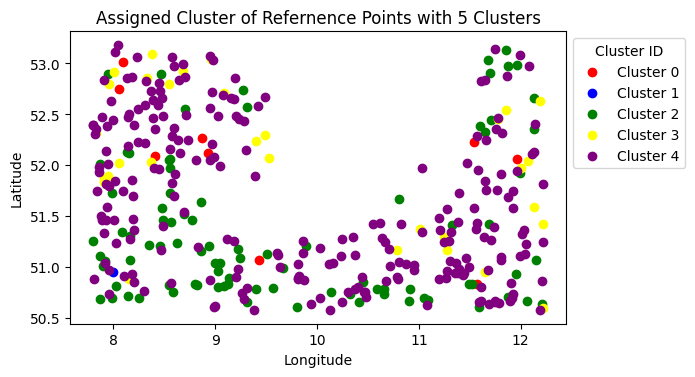

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
# Define a color map for each cluster_id
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'purple'
}
# Split and plot data for each cluster_id
for cluster, color in color_map.items():
    subset = joined_ref_point_geop[joined_ref_point_geop['cluster_id'] == cluster]
    subset.plot(ax=ax, color=color, label=f"Cluster {cluster}")
# Add legend
ax.legend(title="Cluster ID", loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(label="Assigned Cluster of Refernence Points with 5 Clusters", fontsize=12, color="Black")

Text(0.5, 1.0, 'Assigned Cluster of Refernence Points with 5 Clusters')

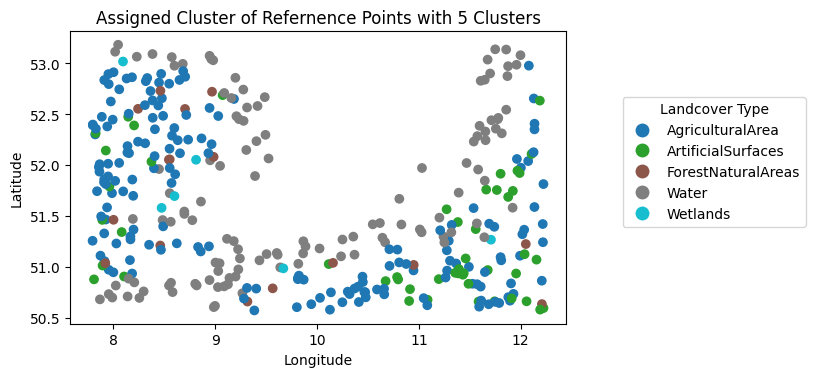

In [59]:
fig, ax = plt.subplots(1,1)
joined_ref_point_geop.plot(ax = ax, column= 'landcover', legend = True,  legend_kwds={'title': 'Landcover Type' ,'bbox_to_anchor':(1.1, 0.8),} )
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(label="Assigned Cluster of Refernence Points with 5 Clusters", fontsize=12, color="Black")

In [60]:
# Convert the reference point with joined cluster_id into pandas dataframe
joined_ref_point= joined_ref_point_geop.drop(['geometry'], axis=1)
joined_ref_point.head()

,landcover,cluster_id
0,AgriculturalArea,4
1,ArtificialSurfaces,4
2,Water,2
3,Water,4
4,ArtificialSurfaces,4


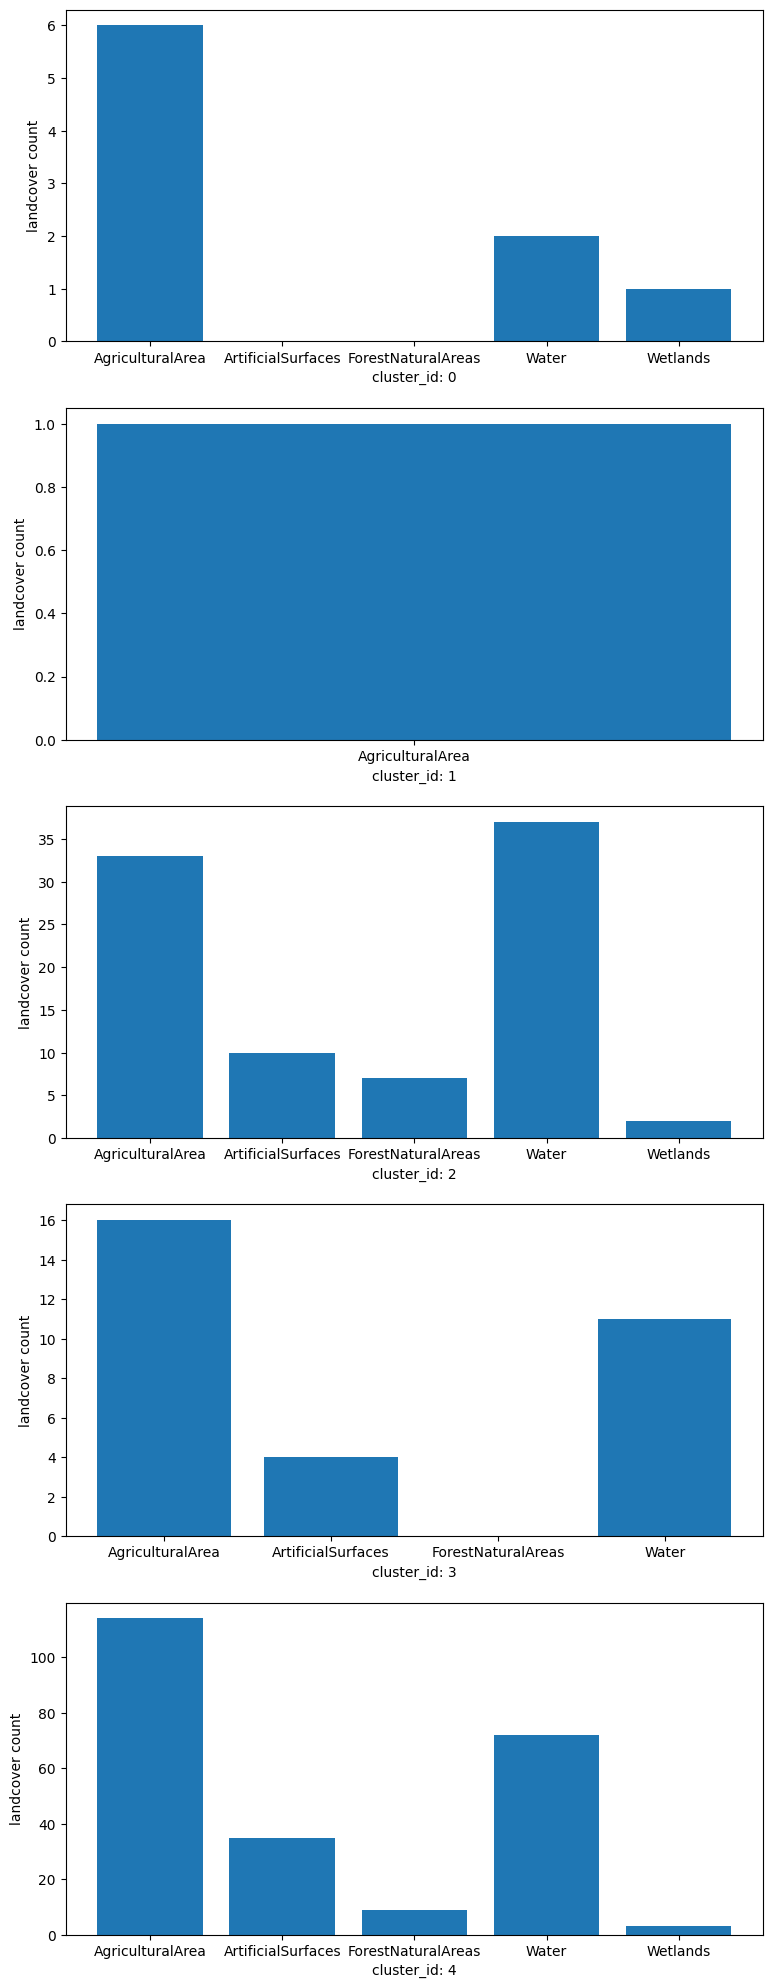

In [61]:
import matplotlib.pyplot as plt
# reshape the dataframe to pivot-table (to calculate the number of different land covers per cluster id)
pivot_table = joined_ref_point.pivot_table(index="landcover", columns="cluster_id", values=None, aggfunc="size")

# build up the sub plots
fig, axs = plt.subplots(ncols=1, nrows=len(pivot_table.columns), figsize=(9, 25))

# to visualise the charts
for i, column in enumerate(pivot_table.columns):
    axs[i].bar(pivot_table.index, pivot_table[column])
    axs[i].set_xlabel("cluster_id: "+str(column))
    axs[i].set_ylabel("landcover count")
    #axs[i].set_title(column)

plt.show()

## 3 Discussion

NB. As sample points for clustering were generated randomly, so the tables and graphs below may not be aligned with the ones in the results of reruning of the codes above.

### 3.1 Training for Unsupervised Classifier in GEE
In traditional unsupervised learning we would give the model all the data and let it come up with the best clusters it sees fit, based on the number of clusters we wish to see. Given that Google Earth Engine has data for the entire globe, it is unreasonable to feed the model all the data. Even with some really nice machines, we would be sitting all day as the many possibilities are considered by the model. Creating a cluster on a subset of data, aka training the unsupervised classifier, is a pragmatic approach to getting some unsupervised learning with overloading our process. Sampleing could have been another, potentially more accurate, term for what is happening here. 

### 3.2 Impact of Cluster Number
The impact of different number of clustered was studied for two different regions in Turkey. The graph presented is for Turkey region 1:

![fig1.png](photos/fig1.png)



![fig2.png](photos/fig2.png)

The graph above shows that the model was run for different number of clusters, starting with a base value of 5. We utilized V-measure score to evaluate the ‘goodness’ of the result. A number close to 1 means more perfect labeling. We observe a performance increase till 15 clusters, after which the performance of the model starts to show a decline.

Clusters 5, 10 and 15 were ran for another region in Turkey (Region 2) having similar land cover.

![fig3.png](photos/fig3.png)

The performance of different clusters in region 1 and 2 from Turkey is similar (refer Table 1). This is expected as the two regions have similar land cover types.  

![table1.png](photos/table1.png)


### 3.3 Clustering Time Comparison
It was observed that the first clustering takes longer as compared to follow up clustering (refer Table 2). It was also expected that with increasing clusters, the computation time would also increase. However, no particular pattern was observed as we increased the cluster size (refer Table 3). We conclude that the run time for clustering is not directly proportional to the cluster size and might depend on other factors (e.g., data properties).

![table2.png](photos/table2.png)
![table3.png](photos/table3.png)




### 3.4 comparing Land Cover and the Clusters

The first map is the reference points from out first Turkey study area plotted with their designated cluster. In this scenario we chose to have five clusters indicated as 0, 1, 2, 3, 4. The second map is of the same study area reference points plotted with their given land cover type. While initially we expected the five landcover types to line up with the five clusters we selected, that didn’t happen. In the landcover plot there is a coastline in the lower left-hand corner indicated with several grey dots. This clear pattern is not represented within the cluster results given just above. Given our unsupervised learning model was given all the bands, not just the ones related to landcover type, to build clusters off of. The clusters encompass a profile that contains more info than just the relationship between B2, B3 and B4 (the bands related to land cover type). 

![fig4.png](photos/fig4.png)

![fig5.png](photos/fig5.png)

We took the same trained cluster and applied it to Germany to see what would happen in a totally new area. The same pattern of disconnection between cluster and land cover emerged again. For example, there are two dots in the middle forming cluster 4, they look to be totally different land cover types. Nor is there a clusters with the same sprinkle pattern of the ForestNaturalAreas. 

![fig6_butactually.png](photos/fig6_butactually.png)

![fig7.png](photos/fig7.png)

The bar charts produced above further added to this point. When we look at any bar chart created with the clusters and the land cover we see that a cluster can have mulitple different land cover types. This indicates that land cover could be a factor in the clusters but not the actual output. The goal of this lab was to practise unsupervised learning,it would be unreasonable if the model we chose was able to produce land cover exactly, let alone unprompted. In future endeavours we could consider running this excersize with only the bands that relate to land cover and see how that compares. 